In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import h5py

## Reading the data

In [6]:
data = h5py.File("catalog0.h5","r")

## Creating a TreeCorr parameter file

In [132]:
def create_par_file(file1,file2,random1,random2,minsep,maxsep,nbins,outfile):
    f = open('parfile.param','w')
    #We assume inputs in fits files
    f.write('file_name ='+file1+'.fits\n')
    f.write('file_name2 ='+file2+'.fits\n')
    f.write('rand_file_name ='+random1+'.fits\n')
    f.write('rand_file_name2 ='+random2+'.fits\n')
    f.write('file_type=FITS\n')
    f.write('ra_col = ra\n')
    f.write('dec_col = dec\n')
    f.write('ra_units=degrees\n')
    f.write('dec_units=degrees\n')
    f.write('min_sep = '+str(minsep)+'\n')
    f.write('max_sep = '+str(maxsep)+'\n')
    f.write('sep_units = degrees\n')
    f.write('nbins = '+str(nbins)+'\n')
    f.write('nn_file_name = '+outfile+'\n')
    f.write('verbose = 2\n')
    f.close()

## Making redshift bins and writing fits files for each bin

In [137]:
def create_fits_file(data,fitsname,zbinwidth=0.1, zmin=0.2,zmax=1.4):
    import astropy.table as t
    photoz = data['objects']['z_red_t']+data['objects']['z_error']*(1+data['objects']['z_red_t'])
    data_tab = t.Table([data['objects']['ra'],data['objects']['dec'],data['objects']['z_red_t'],photoz],
                       names=('ra','dec','z_red','photoz'))
    nbins = int(np.ceil((np.max(photoz)-np.min(photoz))/zbinwidth))
    print 'Number of redshift bins = ',nbins
    for i in range(0,nbins):
        bin_mask = np.logical_and(photoz>=zmin+i*zbinwidth,photoz<zmin+(i+1)*zbinwidth)
        newt = data_tab[bin_mask]
        new_name = fitsname+'_'+str(i)+'.fits'
        newt.write(new_name)

## Creating randoms for galaxy-galaxy 2pcf

In [136]:
def make_randoms(nrandoms,data):
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    
    cthmin = np.cos(np.pi/2-data['window'].attrs['dec_min']*np.pi/180) 
    cthmax = np.cos(np.pi/2-data['window'].attrs['dec_max']*np.pi/180)
    rcth = cthmin + (cthmax-cthmin)*np.random.random(nrandoms)
    rdec = 90-180/np.pi*np.arccos(rcth)
    rra = 360*np.random.random(nrandoms)
    c_icrs = SkyCoord(ra=rra*u.degree, dec=rdec*u.degree, frame='icrs')
    bcut = c_icrs.galactic['b']>data['window'].attrs['b_cut']
    return c_icrs[bcut]

Creating a routine to put the data into a Healpix map

In [17]:
def make_hp_map(nside,data):
    import healpy as hp
    pix_nums = hp.ang2pix(nside,np.pi/2-data['objects']['dec']*np.pi/180,data['objects']['ra']*np.pi/180)
    bin_count = np.bincount(pix_nums)
    map_gal = np.append(bin_count,np.zeros(12*nside**2-len(bin_count)))
    return map_gal

In [18]:
map_gal  = make_hp_map(32,data)

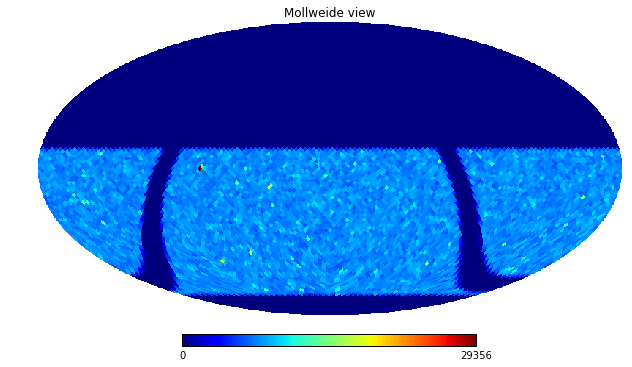

In [19]:
import healpy as hp
hp.mollview(map_gal)

In [77]:
def make_hp_random_map(nside,random):
    import healpy as hp
    import astropy.units as u
    theta_arr = np.array(np.pi/2-random.dec/u.degree*np.pi/180,dtype='float32')
    phi_arr = np.array(random.ra/u.degree*np.pi/180,dtype='float32')
    pix_nums = hp.ang2pix(nside,theta_arr,phi_arr)
    bin_count = np.bincount(pix_nums)
    map_gal = np.append(bin_count,np.zeros(12*nside**2-len(bin_count)))
    return map_gal

In [85]:
def write_random(random,outfile):
    import astropy.table as t
    ra_arr = np.array(random.ra/u.degree,dtype='float32')
    dec_arr = np.array(random.dec/u.degree,dtype='float32')
    r_table = t.Table([ra_arr,dec_arr],names=('ra','dec'))
    r_table.write(outfile+'.fits')

In [ ]:
randoms = make_randoms(5000000,data)

In [82]:
random_map = make_hp_random_map(32,randoms)

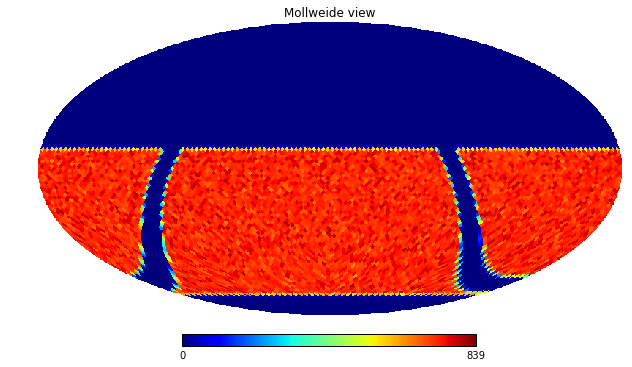

In [83]:
hp.mollview(random_map)

In [86]:
write_random(randoms,'random')

In [89]:
create_fits_file(data,'data',zbinwidth=0.1, zmin=0.2,zmax=1.4)

Number of redshift bins =  12


In [141]:
create_par_file('data_1','data_1','random','random',0.1,30,30,'corr1_1.dat')

## Running TreeCorr

In [95]:
import subprocess

In [109]:
subprocess.call(['corr2', 'parfile.param'])

0

## Plotting the results

In [157]:
def plot_results(results):
    import astropy.table as t
    t_results = t.Table.read(results,format='ascii')
    plt.plot(t_results['R_nom'],t_results['xi'],'o',label=results)
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$w(\theta)$')
    plt.xscale('log')
    plt.figure()
    plt.plot(t_results['R_nom'],t_results['R_nom']**2*t_results['xi'],'o',label=results)
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$w(\theta)\times \theta^{2}$')
    plt.xscale('log')
    plt.legend()

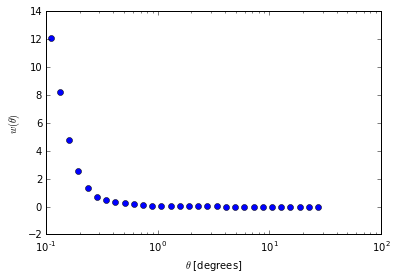

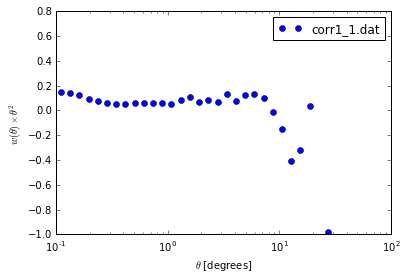

In [158]:
plot_results('corr1_1.dat')

## Running all the bins

In [ ]:
for i in range(0,12):
    for j in range(i,12):
        file1 = 'data_'+str(i)
        file2 = 'data_'+str(j)
        out ='corr_'+str(i)+'_'+str(j)+'.dat'
        create_par_file(file1,file2,'random','random',0.1,30,30,out)
        subprocess.call(['corr2', 'parfile.param'])
        plot_results(out)